In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import time
%matplotlib inline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.linear_model import LinearRegression
import pickle

In [2]:
drama_df = pd.read_csv("./dramas.csv")
drama_df["comments"].fillna(" ", inplace=True)
def k_mean_hypertune(k):
    x_train = drama_df["comments"].dropna()
    y_train = drama_df["rating"].loc[x_train.index].dropna()
    x_train = drama_df["comments"].loc[y_train.index]
    vec = TfidfVectorizer(max_features=100)
    vec.fit(x_train)
    x_train = vec.transform(x_train)
    pipeline = Pipeline([
        ("model", KNeighborsRegressor(n_neighbors=int(round(k))))
    ])
    
    score = cross_val_score(pipeline, x_train, y_train, 
                    cv=10, scoring="neg_mean_squared_error")
    return np.sqrt(-score.mean())

#Generic Series Creator
def set_series(start, end, increment=1, type="int"):
    temp = list(range(start, end, increment))
    series = pd.Series(temp)
    series = series.reindex(temp)
    for x in temp:
        series[x] = x
    
    if type is "int":
        return series.astype(int)
    else:
        return series

In [3]:
k_series = set_series(1, 100, type=float)
k_series = k_series.apply(k_mean_hypertune)

(87, 9.59552331099185)

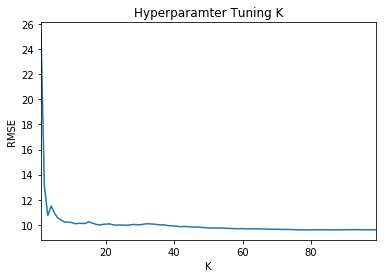

In [4]:
plt.title("Hyperparamter Tuning K")
plt.xlabel("K")
plt.ylabel("RMSE")
k_series.plot.line()
k_val = k_series.idxmin()
(k_series.idxmin(), k_series.min())

In [38]:
pickle.dump(k_series, open("kmeans.pkl", "wb"))

In [5]:
def tfidfvec_tuning(k):
    x_train = drama_df["comments"].dropna()
    y_train = drama_df["rating"].loc[x_train.index].dropna()
    x_train = drama_df["comments"].loc[y_train.index]
    vec = TfidfVectorizer(max_features=int(k))
    vec.fit(x_train)
    x_train = vec.transform(x_train)
    pipeline = Pipeline([
        ("model", KNeighborsRegressor(n_neighbors=k_val))
    ])
    
    score = cross_val_score(pipeline, x_train, y_train, 
                    cv=10, scoring="neg_mean_squared_error")
    return np.sqrt(-score.mean())


(57, 9.55927488636496)

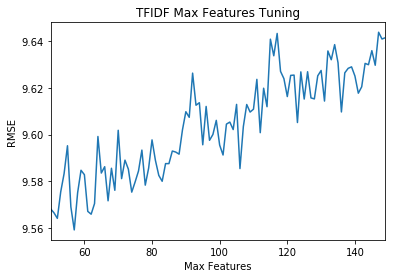

In [6]:
max_f = set_series(50, 150, type="float")
max_f = max_f.apply(tfidfvec_tuning)
plt.title("TFIDF Max Features Tuning")
plt.xlabel("Max Features")
plt.ylabel("RMSE")
max_f.plot.line()
max_f_val = max_f.idxmin()
(max_f.idxmin(), max_f.min())

In [7]:
def tfidfvec_ngram_tuning(k, t):
    x_train = drama_df["comments"].dropna()
    y_train = drama_df["rating"].loc[x_train.index].dropna()
    x_train = drama_df["comments"].loc[y_train.index]
    vec = TfidfVectorizer(max_features=max_f_val, ngram_range=(int(k), int(t)))
    vec.fit(x_train)
    x_train = vec.transform(x_train)
    pipeline = Pipeline([
        ("model", KNeighborsRegressor(n_neighbors=k_val))
    ])
    
    score = cross_val_score(pipeline, x_train, y_train, 
                    cv=10, scoring="neg_mean_squared_error")
    return np.sqrt(-score.mean())

minmax_df = pd.DataFrame()
i = 0
for x in range(1, 11):
    for y in range(x, 11):
        minmax_df.loc[i,"Min"] = x
        minmax_df.loc[i, "Max"] = y
        i += 1
minmax_df["scores"] = minmax_df.apply(lambda x: tfidfvec_ngram_tuning(x["Min"], x["Max"]), axis=1)

({'Min': 1.0, 'Max': 1.0}, 9.55927488636496)

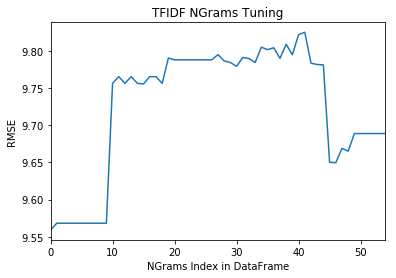

In [8]:
plt.title("TFIDF NGrams Tuning")
plt.xlabel("NGrams Index in DataFrame")
plt.ylabel("RMSE")
minmax_df["scores"].plot.line()
index_scores = minmax_df["scores"].idxmin()
({"Min": minmax_df.loc[index_scores, "Min"],
  "Max" : minmax_df.loc[index_scores, "Max"]}
 , minmax_df["scores"].min())

In [9]:
#Generic Pipe and Train for future models for comments
def pipe_and_train(pipeline):
    x_train = drama_df["comments"].dropna()
    y_train = drama_df["rating"].loc[x_train.index].dropna()
    x_train = drama_df["comments"].loc[y_train.index]

    vec = TfidfVectorizer(max_features=max_f_val)
    vec.fit(x_train)
    x_train = vec.transform(x_train).todense()

    scores = cross_val_score(pipeline, x_train, y_train, 
                             cv=10, scoring="neg_mean_squared_error")
    return np.sqrt(np.mean(-scores))

def try_gpr_alpha(k):
    return (pipe_and_train( 
        GaussianProcessRegressor(alpha=k)))

(0.1, 11.4658810790123)

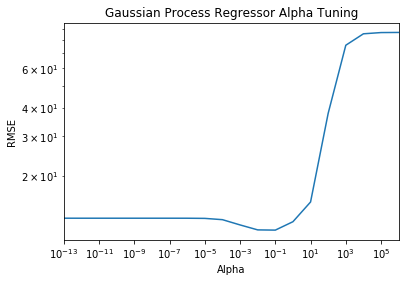

In [10]:
temp = list(range(0,20))
for x in temp:
    temp[x] = 1e-13 * (10 ** x)


gpr_alpha_series = pd.Series(temp)
gpr_alpha_series = gpr_alpha_series.reindex(temp)
for x in temp:
    gpr_alpha_series[x] = x
    
gpr_alpha_series = gpr_alpha_series.apply(try_gpr_alpha)
plt.title("Gaussian Process Regressor Alpha Tuning")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.xscale("log")
plt.yscale("log")
gpr_alpha_series.plot.line()
(gpr_alpha_series.idxmin(), gpr_alpha_series.min())

(0.039, 11.407177440815788)

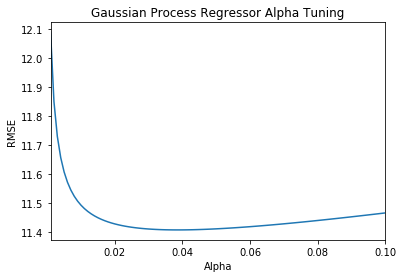

In [11]:
temp = list(range(1, 101))
i = 0
for x in temp:
    temp[i] = round(x * 0.001, 3)
    i += 1
gpr_alpha_series2 = pd.Series()
gpr_alpha_series2 = gpr_alpha_series2.reindex(temp)
for x in temp:
    gpr_alpha_series2[x] = x

gpr_alpha_series2 = gpr_alpha_series2.apply(try_gpr_alpha)
plt.title("Gaussian Process Regressor Alpha Tuning")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
gpr_alpha_series2.plot.line()
gpr_alpha = gpr_alpha_series2.idxmin()
(gpr_alpha_series2.idxmin(), gpr_alpha_series2.min())

In [37]:
pickle.dump(gpr_alpha_series2, open("gpr_alpha.pkl", "wb"))

(200, 36.81687338501499)

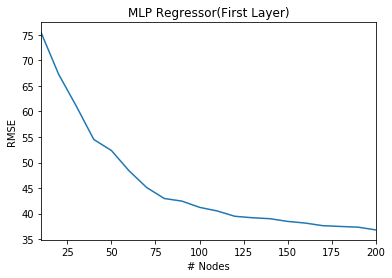

In [12]:
def mlp_first_layer_tuning(k):
    return (pipe_and_train(
        MLPRegressor(
            hidden_layer_sizes=(int(round(k)),))))

import warnings
warnings.filterwarnings("ignore")

mlp_layer1_series = set_series(10, 201, 10, type="float")
mlp_layer1_series = mlp_layer1_series.apply(mlp_first_layer_tuning)
plt.title("MLP Regressor(First Layer)")
plt.xlabel("# Nodes")
plt.ylabel("RMSE")
mlp_layer1_series.plot.line()
layer1 = mlp_layer1_series.idxmin()
(mlp_layer1_series.idxmin(), mlp_layer1_series.min())

In [39]:
pickle.dump(mlp_layer1_series, open("mlp1.pkl", "wb"))

(180, 9.893811793555113)

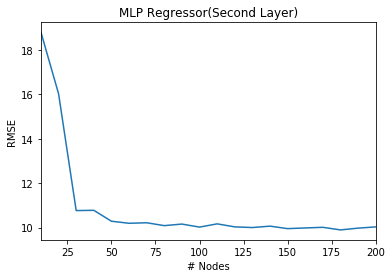

In [13]:
def mlp_second_layer_tuning(k):
    return (pipe_and_train(
        MLPRegressor(
            hidden_layer_sizes=(layer1, int(round(k)),))))

mlp_layer2_series = set_series(10, 201, 10, type="float")
mlp_layer2_series = mlp_layer2_series.apply(mlp_second_layer_tuning)
plt.title("MLP Regressor(Second Layer)")
plt.xlabel("# Nodes")
plt.ylabel("RMSE")
mlp_layer2_series.plot.line()
layer2 = mlp_layer2_series.idxmin()
(mlp_layer2_series.idxmin(), mlp_layer2_series.min())

In [40]:
pickle.dump(mlp_layer2_series, open("mlp2.pkl", "wb"))

(150, 9.491021062368482)

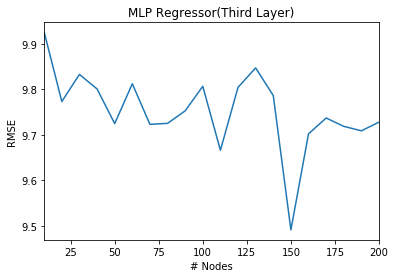

In [14]:
def mlp_third_layer_tuning(k):
    return (pipe_and_train(
        MLPRegressor(
            hidden_layer_sizes=(layer1, layer2, int(round(k)),))))

mlp_layer3_series = set_series(10, 201, 10, type="float")
mlp_layer3_series = mlp_layer3_series.apply(mlp_third_layer_tuning)
plt.title("MLP Regressor(Third Layer)")
plt.xlabel("# Nodes")
plt.ylabel("RMSE")
mlp_layer3_series.plot.line()
layer3 = mlp_layer3_series.idxmin()
(mlp_layer3_series.idxmin(), mlp_layer3_series.min())

In [41]:
pickle.dump(mlp_layer3_series, open("mlp3.pkl", "wb"))

(300, 9.553164534744509)

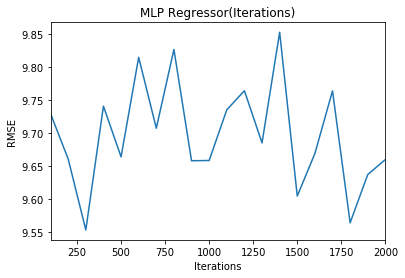

In [15]:
def mlp_iteration_tuning(k):
    return (pipe_and_train(
        MLPRegressor(
            hidden_layer_sizes=(layer1, layer2, layer3,),
            max_iter=int(round(k)))))

mlp_iter_series = set_series(100, 2001, 100, type="float")
mlp_iter_series = mlp_iter_series.apply(mlp_iteration_tuning)
plt.title("MLP Regressor(Iterations)")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
mlp_iter_series.plot.line()
mlp_iter = mlp_iter_series.idxmin()
(mlp_iter_series.idxmin(), mlp_iter_series.min())

In [42]:
pickle.dump(mlp_iter_series, open("mlp_iter.pkl", "wb"))

***ENSEMBLE***

In [16]:
class RegressionEnsembler(BaseEstimator, RegressorMixin):
    """Creates an ensemble model out of a collection of individual estimators
    
    Args:
      estimators: A list containing the individual estimators.
      learn_weights: A boolean that specifies whether we should learn the
        "optimal" weights/coefficients to apply to each individual estimator's
        predictions. If False, we simply return the straight average of the 
        individual estimators' predictions as the ensemble prediction.
    """
    
    def __init__(self, estimators, learn_weights=True):
        self.estimators = estimators
        self.learn_weights = learn_weights
        
    def fit(self, X, y):
        # check that X and y have the correct shape
        X, y = check_X_y(X, y)
        
        # store the training features and the labels
        self.X_ = X
        self.y_ = y
        
        # call the fit method of each of the estimators
        for estimator in self.estimators:
            estimator.fit(X, y)
            
        # if we wish to learn the "optimal" weights from the training data
        if self.learn_weights:
            # get prediction from each estimator on the training data
            predictions = []
            for estimator in self.estimators:
                predictions.append(estimator.predict(X))
            Y_ = np.column_stack(predictions)
        
            # fit linear regression on top of the estimators' predictions
            self.ensembler = LinearRegression(fit_intercept=False)
            self.ensembler.fit(Y_, y)
            
        return self
    
    def predict(self, X):
        # check that fit has been called
        check_is_fitted(self, ['X_', 'y_'])
        
        # check that X has the right form
        X = check_array(X)
        
        # calculate predictions from the estimators
        predictions = []
        for estimator in self.estimators:
            predictions.append(estimator.predict(X))
        Y_ = np.column_stack(predictions)
        
        # return predictions
        if self.learn_weights:
            return self.ensembler.predict(Y_)
        else:
            return Y_.mean(axis=1)

In [17]:
X_train = drama_df["comments"].dropna()
Y_train = drama_df["rating"].loc[X_train.index].dropna()
X_train = drama_df["comments"].loc[Y_train.index]
vec = TfidfVectorizer(max_features=100)
vec.fit(X_train)
X_train = vec.transform(X_train).todense()

def test_ensembles(model1, model2, X_train, Y_train):
    return (np.sqrt(-cross_val_score(model1, X_train, Y_train,
                     cv=20, scoring="neg_mean_squared_error").mean()),
    np.sqrt(-cross_val_score(model2, X_train, Y_train,
                     cv=20, scoring="neg_mean_squared_error").mean()),
    np.sqrt(-cross_val_score(RegressionEnsembler([model1, model2], learn_weights=True), X_train, Y_train,
                     cv=20, scoring="neg_mean_squared_error").mean()),
    np.sqrt(-cross_val_score(RegressionEnsembler([model1, model2], learn_weights=False), X_train, Y_train,
                     cv=20, scoring="neg_mean_squared_error").mean())
    )

In [35]:
#Best models (MLP Regressor + K-Nearest Neighbors)
model1 = KNeighborsRegressor(n_neighbors=k_val)
model2 = MLPRegressor(
            hidden_layer_sizes=(layer1, layer2, layer3,),
            max_iter=mlp_iter)

result_ens = test_ensembles(model1, model2, X_train, Y_train)
result_ens

(9.620903424844128, 9.914297561193337, 9.89116310515767, 9.605758741650307)

In [32]:
#Try GPR
ensemble_model = RegressionEnsembler([model1, model2], learn_weights=False)
gprmodel = GaussianProcessRegressor(alpha=gpr_alpha)

test_ensembles(ensemble_model, gprmodel, X_train, Y_train)

(9.626943043785642, 12.270411754551061, 13.342792090869192, 10.57262249652662)

In [36]:
pickle.dump(ensemble_model, open("model.pkl", "wb"))
pickle.dump(result_ens, open("model_result.pkl", "wb"))

***Markov Chain Comments***

In [21]:
mchain = pickle.load(open("mchain.pkl", "rb"))

In [22]:
for x in mchain: 
    if x < 10:
        print(mchain[x])

In [23]:
def get_word(word):
    if word == "\n":
        return "<N>"
    else:
        return word.lower()
    
def train_markov_chain(lyrics):
    """
    Args:
      - lyrics: a list of strings, where each string represents
                the lyrics of one song by an artist.
    
    Returns:
      A dict that maps a tuple of 2 words ("bigram") to a list of
      words that follow that bigram, representing the Markov
      chain trained on the lyrics.
    """
    chain = {(None, "<START>"): []}
    for lyric in lyrics:
        lyric = lyric.strip()
        tokens = lyric.split(" ")
        prior_word = "<START>"
        word = tokens[0].lower()
        chain[(None,"<START>")].append(word)
        for index in range(1, len(tokens)):
            new_key = (prior_word, word)
            new_word = get_word(tokens[index])
                
            if index == (len(tokens) - 1):
                if new_key in chain:
                    chain[new_key].append("<END>")
                else:
                    chain[new_key] = ["<END>"]
                continue
            
            if new_key in chain:
                chain[new_key].append(new_word)
            else:
                chain[new_key] = [new_word] 
            
            prior_word = word
            word = new_word

    return chain

In [24]:
def train_chain(rating):
    all_comments = []
    high = min(100, rating + 10)
    low = max(0, rating - 10)
    for key in mchain:
        if key <= high and key >= low: 
            all_comments += (mchain[key])
    return train_markov_chain(all_comments)

In [27]:
import random

def generate_new_comment(chain):
    """
    Args:
      - chain: a dict representing the Markov chain,
               such as one generated by generate_new_lyrics()
    
    Returns:
      A string representing the randomly generated song.
    """
    if(len(chain[(None, "<START>")]) == 0):
        return ""
    # a list for storing the generated words
    words = []
    # generate the first word
    prior_word = "<START>"
    word = random.choice(chain[(None, "<START>")])
    if(word == ""):
        return ""
    words.append(word)
    
    new_word = ""
    while (new_word != "<END>"):
        new_word = random.choice(chain[(prior_word, word)])
        words.append(new_word)
        prior_word = word
        word = new_word
    
    
    # join the words together into a string with line breaks
    lyrics = " ".join(words[:-1])
    return "\n".join(lyrics.split("<N>"))

In [28]:
generated_comments = {}
for x in range(0, 101, 10):
    comments = []
    chain = train_chain(x)
    for y in range(0, 6): 
        comments.append(generate_new_comment(chain))
    generated_comments[x] = comments

In [29]:
for keys in generated_comments:
    print(keys)
    for comment in generated_comments[keys]:
        print("\t- " + comment)
    print("\n")

0
	- 
	- 
	- 
	- 
	- 
	- 


10
	- 
	- 
	- 
	- 
	- 
	- 


20
	- 
	- 
	- 
	- 
	- 
	- 


30
	- 
	- 
	- 
	- 
	- 
	- 


40
	- 
	- 
	- 
	- 
	- 
	- 


50
	- 
	- 
	- 
	- 
	- 
	- 


60
	- i didn't feel an iota of satisfaction as there isn't a single story without it for me if ms. fairy husband was the reincarnation of her son was born as a jerk). and about geum, do people really watch this because kang mina (gugudan) project, can't
	- i failed to understand why he was also in river bran. then the unsolved question is the main story which is completely absurd and its just a miracle that web comic version got adapted into a tv
	- tbh, if ever ms. fairy to end up together though. who
	- the worst drama i have been tricked
	- an appropriate title for this
	- their are a lot better." i'll stand by that it has a pure heart. fighting kang sora-ya!!! just watch this regarding on the story


70
	- technically the parents usually collect the money. guests give to the one beside the main leads sparks a ve

In [30]:
pickle.dump(generated_comments, open("gcomments.pkl", "wb"))